# Gradient Boosting

In [2]:
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

import numpy as np
import pandas as pd

model = GradientBoostingClassifier(random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
df = pd.read_csv('..\\data\\data.csv')


# Definisco le variabili feature
features = ['wind_direction', 'concentration', 'U']
X = df[features]
# Definisco la variabile target
y = df['distance']


In [3]:
from sklearn.impute import SimpleImputer
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [4]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

xgb_model = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor', random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
}

grid = GridSearchCV(
    xgb_model,
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

imputer = SimpleImputer(strategy='constant', fill_value=0)
X_train_imputed = imputer.fit_transform(X_train)

grid.fit(X_train_imputed, y_train_enc)
print("Best parameters found: ", grid.best_params_)
print("Best cross-validation score: ", grid.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\abbon\miniconda3\envs\DA\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:52:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\abbon\miniconda3\envs\DA\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:52:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best cross-validation score:  0.7116453209635226


Test set score:  0.75


c:\Users\abbon\miniconda3\envs\DA\Lib\site-packages\xgboost\core.py:2676: UserWarning: [19:05:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
c:\Users\abbon\miniconda3\envs\DA\Lib\site-packages\xgboost\core.py:729: UserWarning: [19:05:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


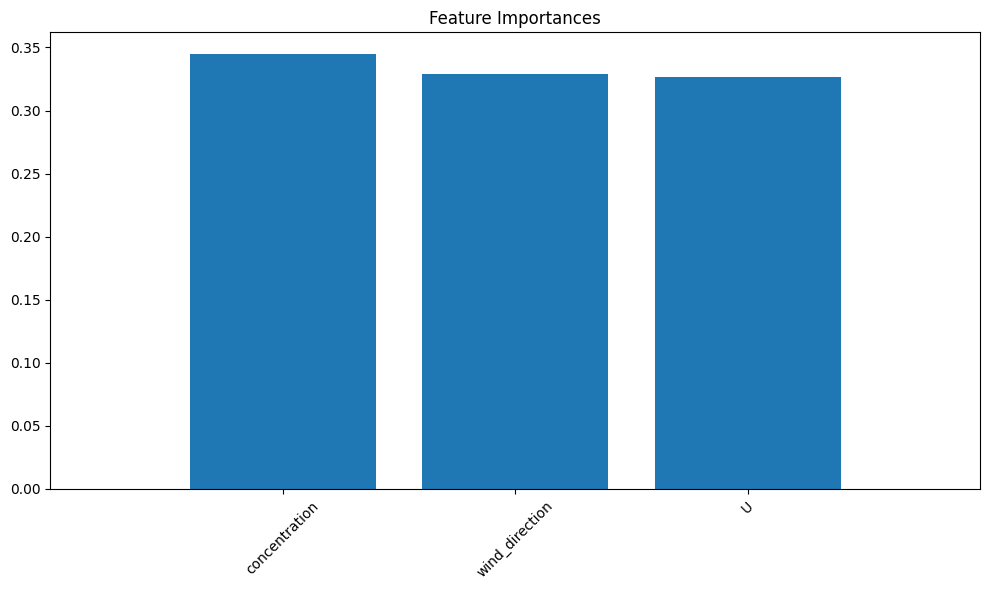

In [5]:
xgb_model = grid.best_estimator_
# Evaluate the model on the test set
X_test_imputed = imputer.transform(X_test)
y_test_enc = le.transform(y_test)
test_score = xgb_model.score(X_test_imputed, y_test_enc)
print("Test set score: ", test_score)
# Plotting feature importances
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), np.array(features)[indices], rotation=45)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [6]:
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test_enc, xgb_model.predict(X_test_imputed)))

Accuracy: 0.75


In [7]:
from sklearn.metrics import classification_report
print("Classification report:\n", classification_report(y_test_enc, xgb_model.predict(X_test_imputed)))

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.81      0.82       234
           1       0.63      0.67      0.65       182
           2       0.78      0.75      0.76       152

    accuracy                           0.75       568
   macro avg       0.75      0.74      0.75       568
weighted avg       0.75      0.75      0.75       568



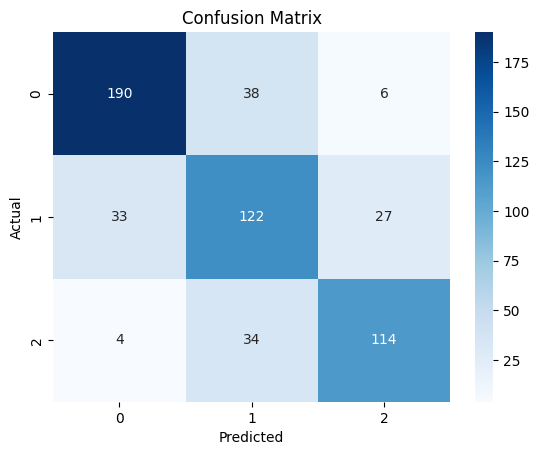

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test_enc, xgb_model.predict(X_test_imputed))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

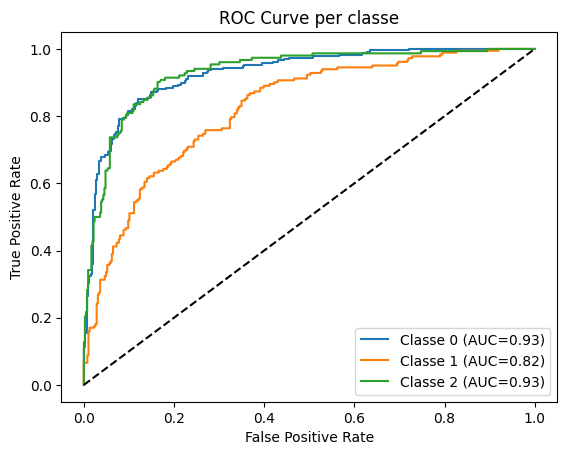

In [9]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_test_enc, classes=np.unique(y_test_enc))
y_score = xgb_model.predict_proba(X_test_imputed)
for i, class_label in enumerate(np.unique(y_test_enc)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f'Classe {class_label} (AUC={auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per classe')
plt.legend()
plt.show()

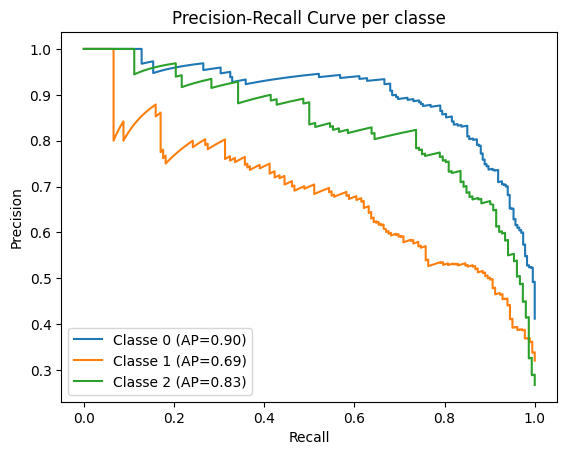

In [10]:
from sklearn.metrics import precision_recall_curve, average_precision_score

for i, class_label in enumerate(np.unique(y_test_enc)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f'Classe {class_label} (AP={average_precision_score(y_test_bin[:, i], y_score[:, i]):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve per classe')
plt.legend()
plt.show()